In [1]:
#!pip install openpyxl
#!pip install hazm
#!pip install textblob
#!pip install numpy
#!pip install pandas
#!pip install ipykernel

### Libraries

In [2]:
import numpy as np   #linear algebra
import pandas as pd  #data processing, CSV file I/O (e.g. pd.read_csv)
from hazm import *
import re
from sklearn.feature_extraction.text import CountVectorizer # import and instantiate CountVectorizer
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn.svm import SVC
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns # for statistical data visualization
import matplotlib.pyplot as plt # for data visualization

### *read data*

In [3]:
dataframe = pd.read_excel('data.xlsx')
dataframe.shape

(100000, 12)

In [4]:
dataframe.head() #Preview the dataset

,product_id,product_title,title_en,user_id,likes,dislikes,verification_status,recommend,title,comment,advantages,disadvantages
0,3692,ماوس بی‌سیم لاجیتک مدل M325,IT,989472,0,0,verified,\N,NaN,واقعا عالیه. من که ازش خیلی راضیم,NaN,NaN
1,90213,شارژر همراه شیاومی مدل NDY-02-AN با ظرفیت 1000...,AC,3862150,4,1,verified,recommended,واقعاً عالیه,سلام، قبل اینکه نظرم رو بگم میخواستم به یک موض...,"[""عمر طولانی\r"",""افت بسیار کم میزان شارژ\r"",""ا...","[""ندارد""]"
2,59473,یدک پولیشر میکروفایبر مهسان مدل 20119,HW,626843,1,0,verified,not_recommended,خیلی سخت حوله اش در میاد,گیره های فلزی خیلی سخت تا میشوند و لذا حوله را...,NaN,NaN
3,120499,گوشی موبایل هوآوی آنر مدل 5X KIW-L21 دو سیم‌کارت,MO,786887,6,11,verified,no_idea,گوشی مقرون به صرفه,همه چیز در رابطه با ظاهر این گوشی بسیار خوب اس...,"[""صفحه نمایش پرنور و با کیفیت\r"",""کیفیت بالای ...","[""کیفیت پایین اسپیکر\r"",""حاشیه خالی زیر صفحه ن..."
4,67200,شارژر همراه شیائومی مدل Mi ظرفیت 5000 میلی آمپ...,AC,854531,19,4,verified,no_idea,ابعاد، استحکام و نگهداری شارژ مناسب,اگر ظرفیتش براتون کافیه حتما بخرید._x000D_\nیه...,"[""ظریف و زیبا و باریک\r"",""بدنه محکم و با دوام""]","[""ظرفیت متوسط""]"


In [5]:
dataframe.dtypes

product_id              int64
product_title          object
title_en               object
user_id                 int64
likes                   int64
dislikes                int64
verification_status    object
recommend              object
title                  object
comment                object
advantages             object
disadvantages          object
dtype: object

In [6]:
normalizer = Normalizer()
print(dataframe['comment'][4])

dataframe = dataframe.dropna()

dataframe['comment'] = dataframe['comment'].apply(lambda x:normalizer.normalize(x)) # Normaliz Text
dataframe['comment'] = dataframe['comment'].apply(lambda x: re.sub('[0-9]+', ' ', x))

print('+++++++++++++++++++++++++++++++++++++++++++++++')
print(dataframe['comment'][4])



اگر ظرفیتش براتون کافیه حتما بخرید._x000D_
یه شارژر 5 ولت 2 آمپر براش تهیه کنید تا سریعتر شارژ شه. خود برند شیائومی شارژر های خوبی داره._x000D_
ظرافتش خوبه و وزن و ضخامت کمی داره و مثل یه موبایل راحت حمل میشه. البته پیشنهاد من ظرفیت های بالاتر هست. چون این مدل بسته به ظرفیت باتری گوشیتون صرفا به اندازه یک الی 2 بار شارژ کردن، انرژی ذخیره میکنه.
+++++++++++++++++++++++++++++++++++++++++++++++
اگر ظرفیتش براتون کافیه حتما بخرید. _x ۰۰۰ D_
یه شارژر ۵ ولت ۲ آمپر براش تهیه کنید تا سریعتر شارژ شه. خود برند شیائومی شارژر‌های خوبی داره. _x ۰۰۰ D_
ظرافتش خوبه و وزن و ضخامت کمی داره و مثل یه موبایل راحت حمل میشه. البته پیشنهاد من ظرفیت‌های بالاتر هست. چون این مدل بسته به ظرفیت باتری گوشیتون صرفا به اندازه یک الی ۲ بار شارژ کردن، انرژی ذخیره میکنه.


In [7]:
#here we keep useful values of'recommend' column in df
#print(dataframe.columns.values)
print(dataframe.recommend.unique())

df = dataframe
df = df[(df['recommend'] == "recommended") | (df['recommend'] == "not_recommended")]
df.shape #Check shape of the dataset

['recommended' 'no_idea' '\\N' 'not_recommended']


(15611, 12)

In [8]:
df = df[((df['likes']/df['dislikes'])>1)&(df['recommend'] == "recommended")
       |((df['recommend'] == "not_recommended")&(df['dislikes']/df['likes']>1))]
df.shape #Check shape of the dataset

(7596, 12)

In [9]:
df = df[['recommend','comment']]
df.head(10) #Preview the dataset

,recommend,comment
1,recommended,سلام، قبل اینکه نظرم رو بگم می‌خواستم به یک مو...
5,recommended,سلام دوستان،، _x ۰۰۰ D_\nمنم مثه بعضی از دوستا...
6,recommended,من چند سالی هست که این اسپیکرو خریدم و واقعا ح...
10,recommended,نزدیک به دو ساله که این هارد رو خریدم. استفاده...
12,recommended,افا از وقتی من اینو واسه پسرم خریدم همه بچه‌ها...
13,recommended,من این پاور بانک رو حدود یک سال پیش از دیجی کا...
20,not_recommended,سلام و خسته نباشید به تمامی کارکنان و بازدید ک...
24,recommended,اگر با قیمتش مشکلی ندارید نسبت به صداش شک نکنی...
26,recommended,آپدیت: دو سال و نیم گذشت از خریدم. بهترین گوشی...
29,recommended,با سلام_x ۰۰۰ D_\nعالیه، امیدوارم شگفت‌انگیز ش...


In [10]:
df.isnull().sum() #Check for missing values in dataset

recommend    0
comment      0
dtype: int64

In [11]:
df.shape #Check shape of the dataset

(7596, 2)

In [12]:
#!pip install textblob

In [13]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['comment'], df['recommend'], test_size=0.25)

encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['comment'])
xtrain_tfidf = tfidf_vect.transform(train_x)
xvalid_tfidf = tfidf_vect.transform(valid_x)
xtrain_tfidf.data

array([0.0771187 , 0.23331889, 0.34412979, ..., 0.12803954, 0.10109354,
       0.20126991])

In [14]:
#print(valid_y)

In [15]:
print("Train shapes : X = {}, y = {}".format(xtrain_tfidf.shape,train_y.shape))
print("Test shapes : X = {}, y = {}".format(xvalid_tfidf.shape,valid_y.shape))

Train shapes : X = (5697, 5000), y = (5697,)
Test shapes : X = (1899, 5000), y = (1899,)


-----
-----

### *Model Generation Logistic Regression*

In [16]:
classifier_LR = linear_model.LogisticRegression()
classifier_LR.fit(xtrain_tfidf,train_y)

pred_LR = classifier_LR.predict(xvalid_tfidf)
print ("Accuracy: ",metrics.accuracy_score(pred_LR, valid_y))


Accuracy:  0.8920484465508162


In [17]:
Accuracy_LR=round(metrics.accuracy_score(pred_LR, valid_y),2)
print("Accuracy_LR(in %):", Accuracy_LR)

Accuracy_LR(in %): 0.89


In [18]:
#print confusion_matrix
print(confusion_matrix(valid_y,pred_LR), ": is the confusion matrix")
print(classification_report(valid_y,pred_LR))

[[  54  199]
 [   6 1640]] : is the confusion matrix
              precision    recall  f1-score   support

           0       0.90      0.21      0.35       253
           1       0.89      1.00      0.94      1646

    accuracy                           0.89      1899
   macro avg       0.90      0.60      0.64      1899
weighted avg       0.89      0.89      0.86      1899



----
----

### *Model Generation SVM*

### *Support Vector Machine (SVM)(Simple)*

In [19]:
# import support vector classifier
# "Support Vector Classifier"
#from sklearn.svm import SVC
classifier_SVM = SVC(kernel='linear')

# fitting x samples and y classes
classifier_SVM.fit(xtrain_tfidf,train_y)


SVC(kernel='linear')

In [20]:
pred_SVM = classifier_SVM.predict(xvalid_tfidf)
print ("Accuracy: ",metrics.accuracy_score(pred_SVM, valid_y))

Accuracy:  0.9083728278041074


In [21]:
Accuracy_SVM=round(metrics.accuracy_score(pred_SVM, valid_y),2)
print("Accuracy_LR(in %):", Accuracy_SVM)

Accuracy_LR(in %): 0.91


In [22]:
print(confusion_matrix(valid_y,pred_SVM), ": is the confusion matrix")
print(classification_report(valid_y,pred_SVM))

[[  95  158]
 [  16 1630]] : is the confusion matrix
              precision    recall  f1-score   support

           0       0.86      0.38      0.52       253
           1       0.91      0.99      0.95      1646

    accuracy                           0.91      1899
   macro avg       0.88      0.68      0.74      1899
weighted avg       0.90      0.91      0.89      1899



---
---

### *GridSearchCV-SVM*

In [23]:
# defining parameter range
#from sklearn.model_selection import GridSearchCV
svm_param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01 ],
              'kernel': ["linear", "rbf", "poly", "sigmoid"]}
 
svm_grid_search_cv = GridSearchCV(estimator=SVC(), param_grid=svm_param_grid, refit = True, cv=8)

In [24]:
# fitting the model for grid search
svm_grid_search_cv.fit(xtrain_tfidf,train_y)

GridSearchCV(cv=8, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']})

In [25]:
# print best parameter after tuning
svm_grid_search_cv.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [26]:
# print how our model looks after hyper-parameter tuning
svm = svm_grid_search_cv.best_estimator_

In [27]:
grid_pred_SVM = svm_grid_search_cv.predict(xvalid_tfidf) 

# print classification report
print(confusion_matrix(valid_y,grid_pred_SVM))
print(classification_report(valid_y, grid_pred_SVM)) 

[[ 119  134]
 [  32 1614]]
              precision    recall  f1-score   support

           0       0.79      0.47      0.59       253
           1       0.92      0.98      0.95      1646

    accuracy                           0.91      1899
   macro avg       0.86      0.73      0.77      1899
weighted avg       0.91      0.91      0.90      1899



In [28]:
Accuracy_SVM_GridSearchCV=round(metrics.accuracy_score(valid_y, grid_pred_SVM),2)
print("Accuracy_SVM_GridSearchCV(in %):", Accuracy_SVM_GridSearchCV)

Accuracy_SVM_GridSearchCV(in %): 0.91


-----
-----

### *Model Generation Decision Tree*

In [29]:
#from sklearn.tree import DecisionTreeClassifier
classifier_DT = DecisionTreeClassifier(criterion="entropy", max_depth=3)
classifier_DT.fit(xtrain_tfidf,train_y)


DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [30]:
pred_DT = classifier_DT.predict(xvalid_tfidf)
print ("Accuracy: ",metrics.accuracy_score(pred_DT, valid_y))

Accuracy:  0.8767772511848341


In [31]:
Accuracy_DT=round(metrics.accuracy_score(pred_DT, valid_y),2)
print("Accuracy_DT(in %):", Accuracy_DT)

Accuracy_DT(in %): 0.88


In [32]:
# print classification report
print(confusion_matrix(valid_y,pred_DT))
print(classification_report(valid_y, pred_DT))

[[  40  213]
 [  21 1625]]
              precision    recall  f1-score   support

           0       0.66      0.16      0.25       253
           1       0.88      0.99      0.93      1646

    accuracy                           0.88      1899
   macro avg       0.77      0.57      0.59      1899
weighted avg       0.85      0.88      0.84      1899



----
----

### *Model Generation Naive Bayes*

BernoulliNB():

In [33]:
#from sklearn.naive_bayes import BernoulliNB
Classifier_bnb = BernoulliNB()  # BernoulliNB()
Classifier_bnb.fit(xtrain_tfidf,train_y)

BernoulliNB()

In [34]:
pred_bnb=Classifier_bnb.predict(xvalid_tfidf)

In [35]:
Accuracy_BernoulliNB=round(metrics.accuracy_score(pred_bnb,valid_y),2)
print("Accuracy_BernoulliNB(in %):", Accuracy_BernoulliNB)

Accuracy_BernoulliNB(in %): 0.91


In [36]:
# print classification report
print(confusion_matrix(valid_y,pred_bnb))
print(classification_report(valid_y, pred_bnb))

[[ 129  124]
 [  48 1598]]
              precision    recall  f1-score   support

           0       0.73      0.51      0.60       253
           1       0.93      0.97      0.95      1646

    accuracy                           0.91      1899
   macro avg       0.83      0.74      0.77      1899
weighted avg       0.90      0.91      0.90      1899



------------

MultinomialNB():

In [37]:
Classifier_mnb = MultinomialNB()  
Classifier_mnb.fit(xtrain_tfidf,train_y)

MultinomialNB()

In [38]:
pred_mnb=Classifier_mnb.predict(xvalid_tfidf)

In [39]:
Accuracy_MultinomialNB=round(metrics.accuracy_score(pred_mnb,valid_y),2)
print("Accuracy_MultinomialNB(in %):", Accuracy_MultinomialNB)

Accuracy_MultinomialNB(in %): 0.87


In [40]:
# print classification report
print(confusion_matrix(valid_y,pred_mnb))
print(classification_report(valid_y, pred_mnb))

[[   1  252]
 [   0 1646]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       253
           1       0.87      1.00      0.93      1646

    accuracy                           0.87      1899
   macro avg       0.93      0.50      0.47      1899
weighted avg       0.88      0.87      0.81      1899



---
---

### *Result*

Text(0.5, 1.0, 'RESULT')

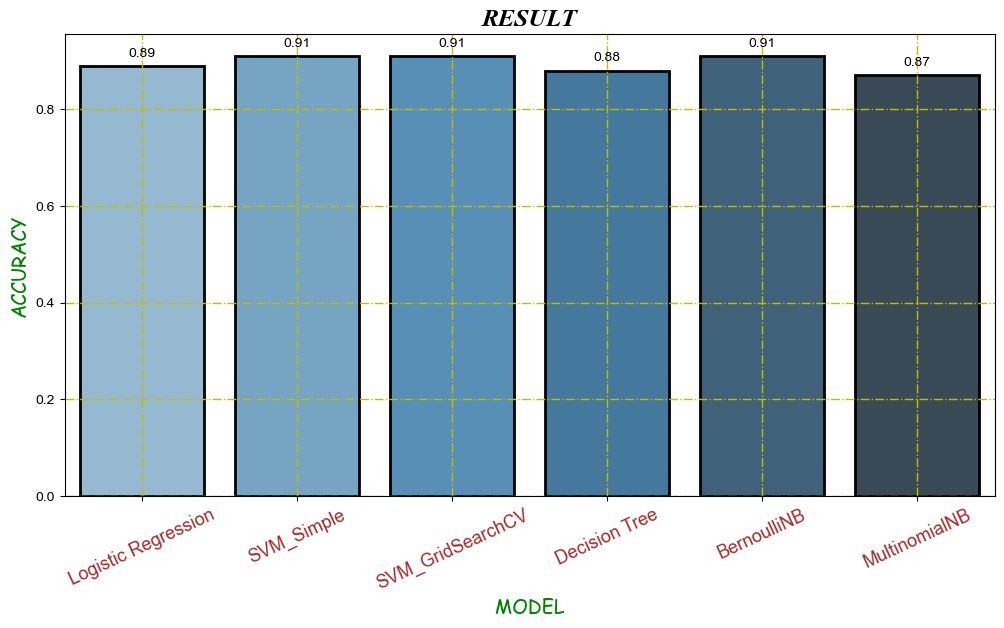

In [41]:
MODEL = ["Logistic Regression","SVM_Simple","SVM_GridSearchCV","Decision Tree","BernoulliNB","MultinomialNB"]
ACCURACY=[Accuracy_LR,Accuracy_SVM,Accuracy_SVM_GridSearchCV,Accuracy_DT,Accuracy_BernoulliNB,Accuracy_MultinomialNB]

df = pd.DataFrame({"MODEL":MODEL, "ACCURACY":ACCURACY})

plt.figure(figsize=(12, 6))

splot=sns.barplot(x="MODEL",y="ACCURACY",data=df, edgecolor = 'black', palette="Blues_d", linewidth=2)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
        
plt.grid(color='y', linestyle='-.', linewidth=1)
#sns.set_style('whitegrid')
sns.set_style('darkgrid')


plt.xticks(rotation=25, horizontalalignment="center", fontsize=13, color='brown')
plt.xlabel("MODEL", fontname='Comic Sans MS',  size=14).set_color('green')
plt.ylabel("ACCURACY", fontname='Comic Sans MS', size=14).set_color('green')
plt.savefig('Result Accuracy.png' ,dpi=200)
plt.title("RESULT",fontname="Times New Roman", fontweight="bold", size=18, style='italic')